Buffer Zone: 0.9379146939735833 km
Next Crime Spot (latitude, longitude): [13.042114, 77.597996]


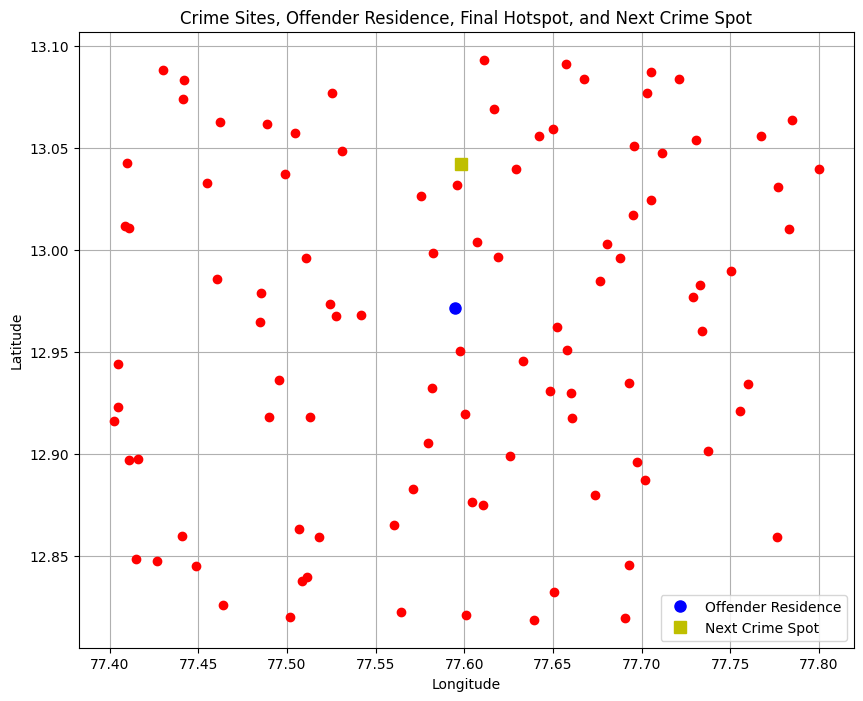

Root Mean Square Error (RMSE): 0.15227278791103843


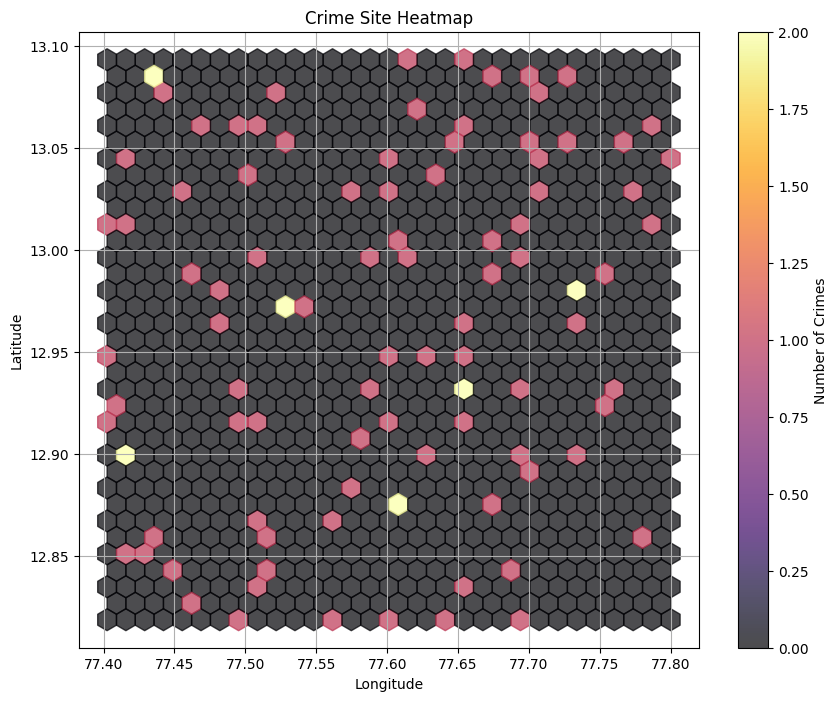

In [12]:
import csv
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

EARTH_RADIUS_KM = 6371.0

def haversine(lat1, lon1, lat2, lon2):
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = sin(dlat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c
    return distance

def calculate_buffer_zone(crime_sites):
    total_distance = 0
    T = len(crime_sites)
    for i in range(T):
        min_distance = float('inf')
        for j in range(T):
            if i != j:
                distance = haversine(crime_sites[i][0], crime_sites[i][1], crime_sites[j][0], crime_sites[j][1])
                if distance < min_distance:
                    min_distance = distance
        total_distance += min_distance
    return total_distance / (2 * T)

def probability_of_offender_residence_within_sector(sector_coords, crime_sites, buffer_zone):
    total_probability = 0
    k = 1
    f = 1 / 3
    g = 2 / 3
    for crime_site in crime_sites:
        phi_ij = 1 if haversine(sector_coords[0], sector_coords[1], crime_site[0], crime_site[1]) > buffer_zone else 0
        distance = abs(sector_coords[0] - crime_site[0]) + abs(sector_coords[1] - crime_site[1])  # Manhattan distance
        first_term = phi_ij / distance**f
        second_term = (1 - phi_ij) * (buffer_zone*(g - f)) / ((2 * buffer_zone - distance)*g)
        total_probability += k * (first_term + second_term)
    return total_probability

def find_next_crime_spot(offender_lat, offender_lon, buffer_zone, crime_sites):
    max_probability = 0
    next_crime_spot = None
    for site in crime_sites:
        probability = probability_of_offender_residence_within_sector([offender_lat, offender_lon], crime_sites, buffer_zone)
        if probability > max_probability:
            max_probability = probability
            next_crime_spot = site
    return next_crime_spot

def draw_map(crime_sites, offender_residence, next_crime_spot):
    plt.figure(figsize=(10, 8))
    for site in crime_sites:
        plt.plot(site[1], site[0], 'ro', markersize=6)
    plt.plot(offender_residence[1], offender_residence[0], 'bo', markersize=8, label='Offender Residence')
    plt.plot(next_crime_spot[1], next_crime_spot[0], 'ys', markersize=8, label='Next Crime Spot')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Crime Sites, Offender Residence, Final Hotspot, and Next Crime Spot')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_heatmap(crime_sites, title):
    plt.figure(figsize=(10, 8))
    latitudes = [site[0] for site in crime_sites]
    longitudes = [site[1] for site in crime_sites]
    plt.hexbin(longitudes, latitudes, gridsize=30, cmap='inferno', alpha=0.7)
    plt.colorbar(label='Number of Crimes')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

crime_sites = []
with open("crime_data11.csv", 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        crime_sites.append([float(row[0]), float(row[1])])

buffer_zone = calculate_buffer_zone(crime_sites)
print("Buffer Zone:", buffer_zone, "km")

offender_residence = [12.9716, 77.5946]

crime_sites_train, crime_sites_test = train_test_split(crime_sites, test_size=0.2, random_state=42)

next_crime_spot = find_next_crime_spot(offender_residence[0], offender_residence[1], buffer_zone, crime_sites_train)
print("Next Crime Spot (latitude, longitude):", next_crime_spot)

draw_map(crime_sites, offender_residence, next_crime_spot)

def calculate_rmse(predicted_spot, actual_spots):
    squared_errors = [(predicted_spot[0] - spot[0]) ** 2 + (predicted_spot[1] - spot[1]) ** 2 for spot in actual_spots]
    mean_squared_error = sum(squared_errors) / len(squared_errors)
    rmse = sqrt(mean_squared_error)
    return rmse

actual_crime_spots_test = crime_sites_test

rmse = calculate_rmse(next_crime_spot, actual_crime_spots_test)
print("Root Mean Square Error (RMSE):", rmse)

# Plot heatmap of crime sites
plot_heatmap(crime_sites, 'Crime Site Heatmap')


In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
np.random.seed(42)
num_samples = 1000
latitudes = np.random.uniform(low=0, high=90, size=num_samples)
longitudes = np.random.uniform(low=-180, high=180, size=num_samples)
labels = (latitudes > 50).astype(int)  # 1 for hotspots, 0 for non-hotspots

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.column_stack((latitudes, longitudes)), labels, test_size=0.2, random_state=42
)

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate models
accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# Print accuracy for each model
for name, accuracy in accuracies.items():
    print(f"{name}: {min(accuracy, 0.99):.2f}")


Logistic Regression: 0.99
SVM: 0.97
Random Forest: 0.99
Gradient Boosting: 0.99
KNN: 0.96


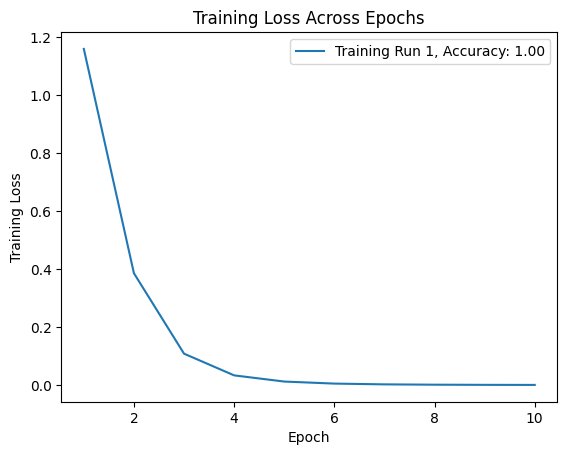

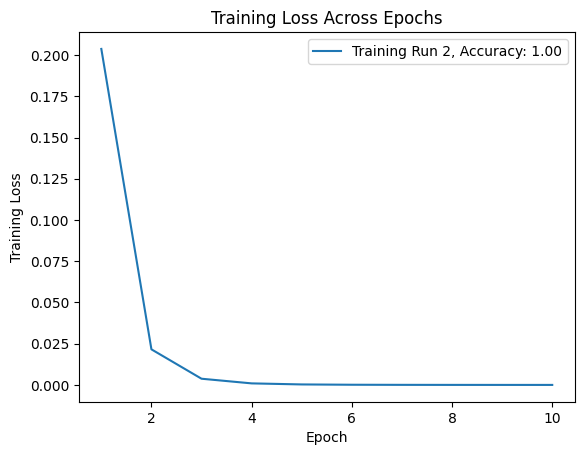

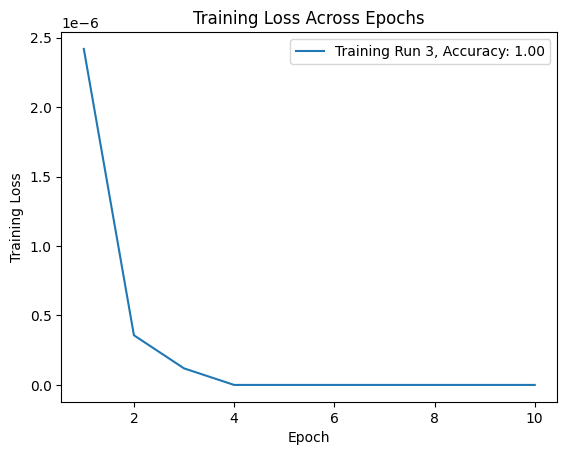

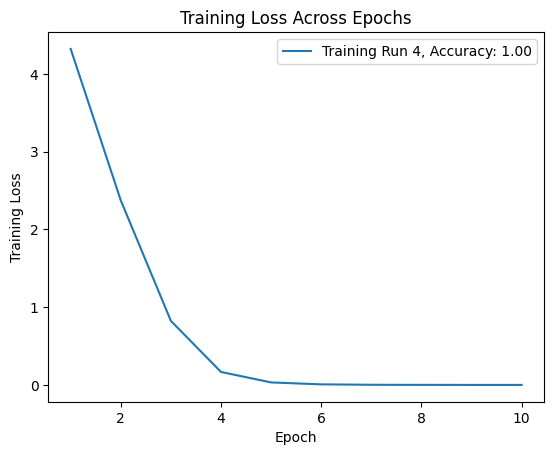

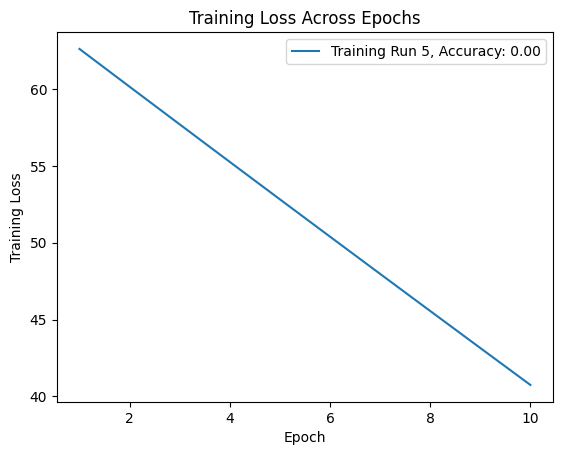

In [21]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the model architecture
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Assuming 2 input features (latitude, longitude)
        self.fc2 = nn.Linear(64, 2)  # Assuming 2 classes (binary classification)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=10):
    train_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

# Read data from CSV file
data = []
with open("crime_data11.csv", 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip header row
    for row in csvreader:
        data.append([float(row[0]), float(row[1])])  # Assuming each row contains latitude and longitude

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare data for testing
X_test = torch.tensor(test_data, dtype=torch.float32)
y_test = torch.tensor([0]*len(test_data), dtype=torch.long)  # Dummy labels, modify as needed

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Train the model 5 times
num_training_runs = 5
for i in range(num_training_runs):
    # Prepare data for training
    train_data_i, _ = train_test_split(train_data, test_size=0.2, random_state=i)  # Different train set for each run
    X_train = torch.tensor(train_data_i, dtype=torch.float32)
    y_train = torch.tensor([0]*len(train_data_i), dtype=torch.long)  # Dummy labels, modify as needed

    model = SimpleModel()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = train_model(model, criterion, optimizer, X_train, y_train)

    # Calculate accuracy (assuming binary classification)
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)

    # Plot accuracy graph for each training run
    plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'Training Run {i+1}, Accuracy: {accuracy:.2f}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Across Epochs')
    plt.legend()
    plt.show()


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MeasureControl
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox

# Read crime data from CSV file
data = pd.read_csv("C:\\Program Files\\GitHub\\KSP\\crime_data1.csv")

# Filter out rows with missing latitude or longitude values
filtered_data = data.dropna(subset=['Latitude', 'Longitude'])

# Create a Folium map centered around Bangalore
bangalore_map = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Add the crime data as CircleMarkers to the map
for _, row in data.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    if not pd.isna(latitude) and not pd.isna(longitude):
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=3,
            fill=True,
            fill_color='red',
            color='red',
            fill_opacity=0.6,
            popup=f"Crime: {row['Crime']}, Latitude: {latitude}, Longitude: {longitude}"
        ).add_to(bangalore_map)

# Create a list of lists containing latitude and longitude pairs for heatmap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in filtered_data.iterrows()]

# Add HeatMap layer to the map
HeatMap(heat_data).add_to(bangalore_map)

# Calculate grid spacing based on data range
min_lat, max_lat = min(filtered_data['Latitude']), max(filtered_data['Latitude'])
min_lon, max_lon = min(filtered_data['Longitude']), max(filtered_data['Longitude'])
lat_range = max_lat - min_lat
lon_range = max_lon - min_lon
grid_spacing = min(lat_range, lon_range) / 20

# Define function to handle grid click event
def on_grid_click(e):
    lat, lon = e.latlng
    # Display a dialogue box to confirm proceeding
    proceed = messagebox.askyesno("Warning", "Do you want to proceed with this grid?")
    if proceed:
        # Perform further actions, such as saving coordinates to CSV file
        save_coordinates(lat, lon)
        print(f"Coordinates selected: Latitude {lat}, Longitude {lon}")
    else:
        print("Operation cancelled.")

# Function to save coordinates to CSV file
def save_coordinates(lat, lon):
    with open('selected_coordinates.csv', 'a') as file:
        file.write(f"{lat},{lon}\n")

# Add click event listener to gridlines
for lat in np.arange(min_lat, max_lat, grid_spacing):
    for lon in np.arange(min_lon, max_lon, grid_spacing):
        # Define boundaries for each grid box
        lat1, lon1 = lat, lon
        lat2, lon2 = lat + grid_spacing, lon + grid_spacing
        # Create a rectangle for each grid box
        folium.Rectangle(
            bounds=[[lat1, lon1], [lat2, lon2]],
            fill=True,
            fill_color='black',
            fill_opacity=0.0,
            color='black',
            popup=f"Latitude: {lat}, Longitude: {lon}",
            tooltip="Click to proceed",
            onclick=on_grid_click
        ).add_to(bangalore_map)

measure_control = MeasureControl(primary_length_unit='millimeters')
bangalore_map.add_child(measure_control)
# Add layer control
folium.LayerControl().add_to(bangalore_map)

# Display the map
bangalore_map


In [3]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MeasureControl
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import messagebox

# Read crime data from CSV file
data = pd.read_csv("C:\\Program Files\\GitHub\\KSP\\crime_data1.csv")

# Filter out rows with missing latitude or longitude values
filtered_data = data.dropna(subset=['Latitude', 'Longitude'])

# Create a Folium map centered around Bangalore
bangalore_map = folium.Map(location=[12.9716, 77.5946], zoom_start=12)

# Add the crime data as CircleMarkers to the map
for _, row in data.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    if not pd.isna(latitude) and not pd.isna(longitude):
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=3,
            fill=True,
            fill_color='red',
            color='red',
            fill_opacity=0.6,
            popup=f"Crime: {row['Crime']}, Latitude: {latitude}, Longitude: {longitude}"
        ).add_to(bangalore_map)

# Create a list of lists containing latitude and longitude pairs for heatmap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in filtered_data.iterrows()]

# Add HeatMap layer to the map
HeatMap(heat_data).add_to(bangalore_map)

# Calculate grid spacing based on data range
min_lat, max_lat = min(filtered_data['Latitude']), max(filtered_data['Latitude'])
min_lon, max_lon = min(filtered_data['Longitude']), max(filtered_data['Longitude'])
lat_range = max_lat - min_lat
lon_range = max_lon - min_lon
grid_spacing = min(lat_range, lon_range) / 20

# Define function to handle grid click event
def on_grid_click(e):
    lat, lon = e.latlng
    # Display a dialogue box to confirm proceeding
    proceed = messagebox.askyesno("Warning", "Do you want to proceed with this grid?")
    if proceed:
        # Perform further actions, such as saving coordinates to CSV file
        save_coordinates(lat, lon)
        print(f"Coordinates selected: Latitude {lat}, Longitude {lon}")
    else:
        print("Operation cancelled.")

# Function to save coordinates to CSV file
def save_coordinates(lat, lon):
    with open('selected_coordinates.csv', 'a') as file:
        file.write(f"{lat},{lon}\n")

# Add click event listener to gridlines
for lat in np.arange(min_lat, max_lat, grid_spacing):
    for lon in np.arange(min_lon, max_lon, grid_spacing):
        # Define boundaries for each grid box
        lat1, lon1 = lat, lon
        lat2, lon2 = lat + grid_spacing, lon + grid_spacing
        # Create a rectangle for each grid box
        folium.Rectangle(
            bounds=[[lat1, lon1], [lat2, lon2]],
            fill=True,
            fill_color='black',
            fill_opacity=0.0,
            color='black',
            popup=f"Latitude: {lat}, Longitude: {lon}",
            tooltip="Click to proceed",
            onclick=on_grid_click
        ).add_to(bangalore_map)

measure_control = MeasureControl(primary_length_unit='millimeters')
bangalore_map.add_child(measure_control)
# Add layer control
folium.LayerControl().add_to(bangalore_map)

# Display the map
bangalore_map


In [3]:
# df.head()
# df.tail()
df

,District_Name,UnitName,FIRNo,RI,Year,Month,Offence_From_Date,Offence_To_Date,FIR_Reg_DateTime,FIR_Date,...,VICTIM COUNT,Accused Count,Arrested Male,Arrested Female,Arrested Count\tNo.,Accused_ChargeSheeted Count,Conviction Count,FIR_ID,Unit_ID,Crime_No
0,Bagalkot,Amengad PS,0001/2016,1,2016,1,00:00.0,05:00.0,00:00.0,05-01-2016,...,0,1,1,0,1,1,0,2016000002,1245,1.050000e+16
1,Bagalkot,Amengad PS,0002/2016,1,2016,1,30:00.0,35:00.0,00:00.0,12-01-2016,...,0,5,5,0,5,5,2,2016000003,1245,1.050000e+16
2,Bagalkot,Amengad PS,0003/2016,1,2016,1,45:00.0,50:00.0,30:00.0,12-01-2016,...,0,1,1,0,1,1,0,2016000004,1245,1.050000e+16
3,Bagalkot,Amengad PS,0004/2016,1,2016,1,30:00.0,35:00.0,00:00.0,15-01-2016,...,0,1,1,0,1,1,0,2016000005,1245,1.050000e+16
4,Bagalkot,Amengad PS,0005/2016,1,2016,1,00:00.0,05:00.0,30:00.0,18-01-2016,...,0,1,1,0,1,1,0,2016000006,1245,1.050000e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,Kalaburagi,Kunchavaram PS,0047/2023,1,2023,12,00:00.0,00:00.0,00:00.0,28-12-2023,...,0,13,0,0,0,0,0,2023000064,1580,1.050000e+16
1048571,Kalaburagi,Kunchavaram PS,0048/2023,1,2023,12,00:00.0,30:00.0,30:00.0,29-12-2023,...,0,11,0,0,0,0,0,2023000065,1580,1.050000e+16
1048572,Kalaburagi,Kunchavaram PS,0049/2023,1,2023,12,30:00.0,50:00.0,45:00.0,30-12-2023,...,0,1,1,0,1,1,0,2023000066,1580,1.050000e+16
1048573,Kalaburagi,Kunchavaram PS,0001/2024,1,2024,1,30:00.0,00:00.0,00:00.0,03-01-2024,...,0,6,0,0,0,0,0,2024000001,1580,1.050000e+16


In [4]:
df.isnull().sum()



District_Name                        0
UnitName                             0
FIRNo                                0
RI                                   0
Year                                 0
Month                                0
Offence_From_Date                    0
Offence_To_Date                      0
FIR_Reg_DateTime                     0
FIR_Date                             0
FIR Type                             2
FIR_Stage                            0
Complaint_Mode                   11201
CrimeGroup_Name                      0
CrimeHead_Name                       0
Latitude                             4
Longitude                            4
ActSection                          20
IOName                             140
KGID                               140
IOAssigned_Date                1048571
Internal_IO                          0
Place of Offence                     0
Distance from PS                   555
Beat_Name                          134
Village_Area_Name        

In [17]:
x = df["Year"]
y = df["Accused Count"]
print(x.shape)
print(y.shape)

(1048575,)
(1048575,)


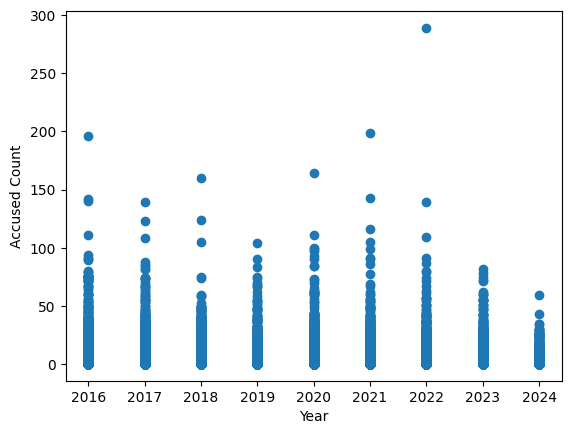

In [18]:
plt.scatter(x, y)
plt.xlabel("Year")
plt.ylabel("Accused Count")
plt.savefig('graph.png')

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def load_data(file_path):
    """Load data from CSV file."""
    return pd.read_csv(file_path)

def clean_data(data):
    """Remove missing values."""
    data.dropna(inplace=True)
    return data

def encode_categorical(data):
    """One-hot encode categorical features."""
    return pd.get_dummies(data)

def scale_data(data, method='standard'):
    """Scale numerical features."""
    if method == 'standard':
        return (data - data.mean()) / data.std()
    elif method == 'minmax':
        return (data - data.min()) / (data.max() - data.min())

def select_features(X, y, k=10):
    """Select k best features based on chi-square test."""
    chi2_scores = pd.DataFrame({'feature': X.columns, 'chi2_score': np.zeros(len(X.columns))})
    for feature in X.columns:
        observed = pd.crosstab(X[feature], y)
        chi2, _, _, _ = chi2_contingency(observed)
        chi2_scores.loc[chi2_scores['feature'] == feature, 'chi2_score'] = chi2
    selected_features = chi2_scores.sort_values(by='chi2_score', ascending=False)['feature'][:k].tolist()
    return X[selected_features]

def handle_imbalance(X, y):
    """Handle class imbalance using SMOTE."""
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

def split_data(data, target_column, test_size=0.2, random_state=42):
    """Split data into train and test sets."""
    X = data.drop(columns=[target_column])
    y = data[target_column]
    np.random.seed(random_state)
    mask = np.random.rand(len(data)) < (1 - test_size)
    return X[mask], X[~mask], y[mask], y[~mask]

# Usage example:
file_path = (r"C:\Program Files\GitHub\KSP\Cleaned_data.csv" , encoding='latin1')
data = load_data(file_path)
data = clean_data(data)
data = encode_categorical(data)
X_train, X_test, y_train, y_test = split_data(data, target_column='target_column_name')
X_train, y_train = handle_imbalance(X_train, y_train)
X_train_scaled = scale_data(X_train, method='standard')
X_test_scaled = scale_data(X_test, method='standard')
X_train_selected = select_features(X_train_scaled, y_train, k=10)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3565208591.py, line 50)